# ELMo and BERT Contextual Embeddings

In this notebook, we use contextual embeddings from ELMo/BERT to study semantic change of conversion.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition
import random

import src.corpus
import src.semantic_embedding

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Parse the corpus

In [2]:
#UD_FILE = "../data/en_ewt-ud-train.conllu"
#corpus = src.corpus.POSCorpus.create_from_ud(data_file_path=UD_FILE)

BNC_FILE = "../data/bnc/bnc.pkl"
corpus = src.corpus.POSCorpus.create_from_bnc_pickled(data_file_path=BNC_FILE)

## Compute embeddings on random part of the corpus

In [3]:
# Take only 1M words out of 4M to make it run faster
SAMPLE_PROPORTION = 1.0
random.seed(12345)
random_indices = random.sample(range(len(corpus.sentences)), int(SAMPLE_PROPORTION * len(corpus.sentences)))

sampled_sentences = []
for ix in random_indices:
  sampled_sentences.append(corpus.sentences[ix])
  
embedder = src.semantic_embedding.SemanticEmbedding(sampled_sentences)
embedder.init_bert(layer=12)

100%|██████████| 17308/17308 [09:05<00:00, 31.75it/s]


## Compute embeddings of instances of a fixed lemma

In [4]:
FIXED_LEMMA = "store"
noun_embeddings, verb_embeddings = embedder.get_bert_embeddings_for_lemma(FIXED_LEMMA)
print("Noun instances:", noun_embeddings.shape[0])
print("Verb instances:", verb_embeddings.shape[0])

Noun instances: 85
Verb instances: 152


## Apply PCA and plot

In [5]:
pca = sklearn.decomposition.PCA(n_components=2)
all_embeddings = pca.fit_transform(np.vstack([noun_embeddings, verb_embeddings]))
all_embeddings_df = pd.DataFrame({'x0': all_embeddings[:,0], 'x1': all_embeddings[:,1]})
all_embeddings_df['pos'] = ['noun'] * len(noun_embeddings) + ['verb'] * len(verb_embeddings)

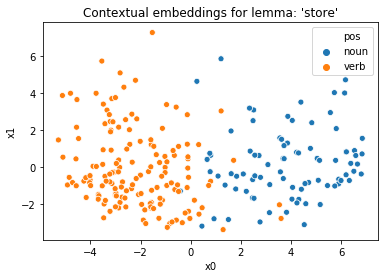

In [6]:
plot = sns.scatterplot(data=all_embeddings_df, x='x0', y='x1', hue='pos')
plot.set(title="Contextual embeddings for lemma: '%s'" % FIXED_LEMMA)
plt.show()

## Utility to inspect what it's capturing

## Cosine similarity between noun and verb usages

In [7]:
lemma_count_df = corpus.get_per_lemma_stats()

# Filter: must have at least [x] noun and [x] verb usages
lemma_count_df = lemma_count_df[(lemma_count_df['noun_count'] >= 80) & (lemma_count_df['verb_count'] >= 80)]
lemma_count_df = lemma_count_df.sort_values('total_count', ascending=False)
lemma_count_df = lemma_count_df[~lemma_count_df.lemma.isin(['go', 'will', 'may'])]
print('Remaining lemmas:', len(lemma_count_df))

Remaining lemmas: 138


In [8]:
lemma_count_df[['nv_cosine_similarity', 'n_variation', 'v_variation']] = \
  lemma_count_df.apply(lambda row: embedder.get_contextual_nv_similarity(row.lemma, method="bert"),
                       axis=1, result_type="expand")

In [9]:
lemma_count_df[['lemma', 'noun_count', 'verb_count', 'majority_tag', 'nv_cosine_similarity']] \
  .sort_values('nv_cosine_similarity').head(8)

,lemma,noun_count,verb_count,majority_tag,nv_cosine_similarity
1216,wave,402,120,NOUN,0.777388
11221,store,95,158,VERB,0.777520
881,deal,191,315,VERB,0.781148
1258,base,109,378,VERB,0.791556
2603,train,224,94,NOUN,0.793843
2599,tear,124,89,NOUN,0.797432
550,press,130,188,VERB,0.798518
2988,note,287,361,VERB,0.804304


In [10]:
lemma_count_df[['lemma', 'noun_count', 'verb_count', 'majority_tag', 'nv_cosine_similarity']] \
  .sort_values('nv_cosine_similarity', ascending=False).head(8)

,lemma,noun_count,verb_count,majority_tag,nv_cosine_similarity
2554,sleep,171,291,VERB,0.965261
2828,cut,92,488,VERB,0.950882
2455,smell,141,149,VERB,0.950325
1617,control,519,179,NOUN,0.950249
2454,drink,456,315,NOUN,0.949481
257,play,185,1093,VERB,0.948823
406,work,1665,1593,NOUN,0.947870
5865,love,495,573,VERB,0.947067


/h/bai/moar/bai-conda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


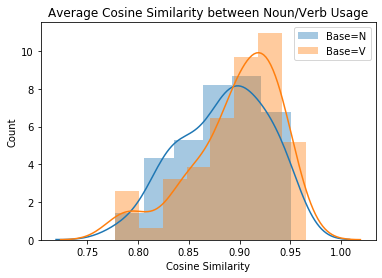

In [11]:
plot = sns.distplot(lemma_count_df[lemma_count_df.majority_tag == 'NOUN'].nv_cosine_similarity, label='Base=N')
plot = sns.distplot(lemma_count_df[lemma_count_df.majority_tag == 'VERB'].nv_cosine_similarity, label='Base=V')
plt.legend()
plot.set(title="Average Cosine Similarity between Noun/Verb Usage",
         xlabel="Cosine Similarity", ylabel="Count")
plt.show()

In [12]:
# T-test of difference in mean
import scipy.stats
scipy.stats.ttest_ind(lemma_count_df[lemma_count_df.majority_tag == 'NOUN'].nv_cosine_similarity,
                      lemma_count_df[lemma_count_df.majority_tag == 'VERB'].nv_cosine_similarity)

Ttest_indResult(statistic=-1.6518602168626335, pvalue=0.10087011158140109)